## THIS IS A NOTEBOOK TO TEST THE VISUAL TRANSFORMER TO RECOGNIZE THE STYLE OF A DIGITALIZED ARTWORK

Consider _"The last supper"_ of **Leonardo Da Vinci** 

This artwork has **high renaissance** as style. Let's see what the model predicts for this artwork

In [1]:
from torchvision import transforms
from load_dataset.artgraph import ArtGraph
import torch_geometric.transforms as T
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch
from torch_geometric.nn import HeteroConv, GATConv
from torch.nn import Linear
import torch.nn.functional as F
from torch import nn
import os
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import ModelClassification

import random
from PIL import Image
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

**SET HERE YOUR SEED AND THE DEVICE**

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(44)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
img_path = 'images-resized/leonardo-da-vinci_the-last-supper-1495.jpg'

In [2]:
img_path = 'image_resized/leonardo-da-vinci_the-last-supper-1495.jpg'

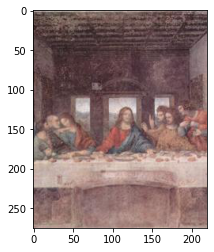

In [4]:
plt.imshow(Image.open(img_path))

In [5]:
def get_image(img_path, transform):
    image = Image.open(img_path)
    if(image.mode != 'RGB'):
        image = image.convert('RGB')
    tensor_image = transform(image)
    return tensor_image

In [6]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [7]:
#getting the image as a tensor
tensor_image = get_image(img_path, data_transforms).to(device)

### LOADING THE FINE-TUNED MODEL

In [8]:
model = torch.load('vit_fine_tune_style.pt').to(device)

In [13]:
prob_distribution = model(tensor_image.reshape((1, *tuple(tensor_image.shape), )))
prob_distribution = nn.Softmax(dim = 1)(prob_distribution)

In [14]:
predicted_style = torch.max(prob_distribution, dim = 1)
predicted_style

torch.return_types.max(
values=tensor([0.1675], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([22], device='cuda:0'))

In [16]:
style2name = pd.read_csv('artgraph2bestemotions/mapping/style_entidx2name.csv', names = ['idx', 'name'])
style2name

,idx,name
0,0,art deco
1,1,art nouveau (modern)
2,2,baroque
3,3,expressionism
4,4,contemporary realism
5,5,neo-expressionism
6,6,magic realism
7,7,cubism
8,8,northern renaissance
9,9,early renaissance


In [17]:
style2name[style2name['name'] == 'high renaissance'].idx

13    13
Name: idx, dtype: int64

As you can see, if you address the discriminator to classify the correct style, you could add a lot of noise into the model, in addition to the high variance that the diffusion model has, as you have already told me.

For this reason, I trurly recommend you to construct better the data. For this I recommend you something like that:

In [19]:
sug_dataset = pd.read_csv('suggested_dataset_structure.csv')
sug_dataset

,artwork,style
0,zinaida-serebriakova_menton-beach-with-umbrell...,art deco
1,erte_autumn-song.jpg,art deco
2,erte_feathers.jpg,art deco
3,john-austen_hamlet-6.jpg,art deco
4,zinaida-serebriakova_bath-1926.jpg,art deco
5,john-vassos_illustration-for-oscar-wilde-s-sal...,art deco
6,erte_simone.jpg,art deco
7,erte_lovers-and-idol.jpg,art deco
8,erte_the-aces-diamonds.jpg,art deco
9,erte_the-zodiac-virgo.jpg,art deco


Please I beg your pardon for the dummy demonstration.

In my opinion a solution to the noise of the classificator could be to use this information in the following way:

1. Feed the batch images into the classificator (discriminator);
2. Take the column which refers to the true style of the artwork;
3. Take the top $k$ artworks which maximize the values of the target column

Note that the column corresponds to the style. For example column 0 (the first) corresponds to _art deco_ (see the variable ```style2name```)